In [1]:
import ast
from collections import defaultdict, Counter
from datetime import datetime, timezone, timedelta
from functools import lru_cache
import itertools
import math
import os
import random
import statistics
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import nltk
import numpy as np
import pandas as pd
from rich.console import Console
from rich.table import Table
from rich import print as rprint
from scipy.stats import norm, pearsonr

%load_ext autoreload
%autoreload 2
from preprocessing.namedtuples import Article, Span, Line

import seaborn as sns

In [2]:
# 1. Distribution of articles per language
# 2. Distribution of techniques per language
# 3. Distribution of techniques per article
# 4. Length of articles per language
# 5. Length of span per technique
# 6. Length of titles
# 7. Most common pairs of techniques per line (most common triplets, quadruplets, etc.)
# 8. What is the max amount of techniques per line?
# 9. 

In [8]:
from preprocessing.init_data import init_raw_data

sentence_id_to_sentence, article_id_to_sentences = init_raw_data(
    train_set=True,
    dev_set=True,
    test_set=False
)
# note, article_ids are not in consecutive order, and are the same as provided in the original data

INFO:init_data:Loading data...
100%|██████████| 9/9 [00:00<00:00, 39.02it/s]


In [45]:
def generate_cooccurence_dfs(languages, techniques_list):
    cooccurence_df = pd.DataFrame(index=techniques_list, columns=techniques_list).fillna(0)
    corr_matrices = {"all": cooccurence_df}
    for lang in languages:
        corr_matrices[lang] = cooccurence_df.copy()
    return corr_matrices

def populate_cooccurence_dfs(cooccurence_dict, language, techniques):
    if len(techniques) >= 2:
        for index, tech1 in enumerate(techniques):
            for tech2 in techniques[index + 1:]:
                cooccurence_dict["all"].loc[tech1, tech2] += 1
                cooccurence_dict["all"].loc[tech2, tech1] += 1
                cooccurence_dict[language].loc[tech1, tech2] += 1
                cooccurence_dict[language].loc[tech2, tech1] += 1

def get_graph_data(techniques_list, technique_categories):
    languages = ["en", "fr", "ge", "it", "po", "ru"]
    
    distribution = defaultdict(int)
    length = defaultdict(list)
    line_techniques_df = pd.DataFrame(index=languages, columns=techniques_list).fillna(0)
    article_techniques_df = line_techniques_df.copy()

    most_common_sets = defaultdict(lambda: {"count": 0})
    cooccurence_dict = generate_cooccurence_dfs(languages, techniques_list)
    
    for article in article_id_to_sentences.values():
        used_techniques = set()
        lang = article[0][3]
        distribution[lang] += 1
        
        article_length = 0
        for line in article:
            article_length += len(line[2])
            line_techniques = list(filter(lambda technique: technique != "", line.techniques))
            techniques_length = len(line_techniques)
            
            populate_cooccurence_dfs(cooccurence_dict, lang, line_techniques)
            
            if 1 < techniques_length < 5:
                techniques_key = frozenset(line_techniques)
                most_common_sets[techniques_key]["count"] += 1
                most_common_sets[techniques_key]["type"] = techniques_length
            
            for technique in line_techniques:
                used_techniques.add(technique)
                line_techniques_df.loc[lang, technique] += 1
        for technique in used_techniques:
            article_techniques_df.loc[lang, technique] += 1
        
        length[lang].append(article_length)
        
        
    line_categories_df = pd.DataFrame(index=languages)
    article_categories_df = line_categories_df.copy()
    
    for key in technique_categories:
        line_categories_df[key] = line_techniques_df.loc[:, technique_categories[key]].sum(axis=1)
        article_categories_df[key] = article_techniques_df.loc[:, technique_categories[key]].sum(axis=1)
        
    return distribution, length, line_techniques_df, line_categories_df, article_techniques_df, article_categories_df, pd.DataFrame.from_dict(most_common_sets).transpose(), cooccurence_dict

def plot_heatmap(ax, data, title, annotate=False, cbar=True):
    ax = sns.heatmap(
        data, 
        cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True),
        square=True, ax=ax, annot=annotate, fmt=".5g", cbar=cbar

    )

    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right',
        size="large"
    )

    ax.set_yticklabels(
        ax.get_yticklabels(),
        rotation=0,
        horizontalalignment='right', 
        size="large"
    )
    
    ax.set_title(title, size="large")

In [46]:
def load_graphs(language_dist, language_length, line_techniques_df, line_categories_df, article_techniques_df, article_categories_df, most_common_sets, cooccurence_dict):
    sns.set()


    fig, axes = plt.subplots(6, 3, figsize=(60, 120))
    ax = axes[0, 0]
    ax.bar(language_dist.keys(), language_dist.values())
    ax.set_ylabel("Number of articles", size="large")
    ax.set_title("Distribution of articles per languages", size="large")

    ax = axes[1, 0]
    ax.boxplot(language_length.values(), labels=language_length.keys())
    ax.set_ylabel("Number of characters", size="large")
    ax.set_title("Lengths of articles per languages", size="large")

    plot_heatmap(axes[0, 1], line_techniques_df, "Distribution of techniques per line per language", True) 
    plot_heatmap(axes[1, 1], article_techniques_df, "Distribution of techniques per article per language", True) 
    plot_heatmap(axes[0, 2], line_categories_df, "Distribution of technique categories per line per language", True) 
    plot_heatmap(axes[1, 2], article_categories_df, "Distribution of technique categories per article per language", True) 
    

    pair_types = ["pairs", "triplets", "quadruplets"]

    for index, pair in enumerate(pair_types):
        sorted_pairs = most_common_sets.loc[most_common_sets["type"] == 2 + index].sort_values("count", ascending=False)["count"].iloc[:10]
        ax = axes[2, index]
        x_labels = [", ".join(index) for index in sorted_pairs.index.array]
        ax.bar(x_labels, sorted_pairs.values)
        ax.set_title(f"Most common technique {pair}", size="large")
        ax.set_xticklabels(x_labels, rotation = 45, ha="right")
    
    x = 0
    y = 3
    for key in cooccurence_dict:
        plot_heatmap(axes[y, x], cooccurence_dict[key], f"Co-occurence matrix of techniques - {key}")
        if x == 2:
            x = 0
            y += 1
        else:
            x += 1

    fig.tight_layout()
    plt.show()

In [55]:
with open("./data/scorers/techniques_subtask3.txt") as file:
    techniques_list = file.read().strip().split("\n")
    
with open("technique_categories.txt") as file:
    technique_categories = {}
    for index, line in enumerate(file):
        line = line.strip()
        if index % 2 == 0:
            category_name = line
        else:
            technique_categories[category_name] = line.split(",")
data_results = get_graph_data(techniques_list, technique_categories)

C:\Users\timoh\AppData\Local\Temp/ipykernel_21796/3289200.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation = 45, ha="right")
C:\Users\timoh\AppData\Local\Temp/ipykernel_21796/3289200.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation = 45, ha="right")
C:\Users\timoh\AppData\Local\Temp/ipykernel_21796/3289200.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation = 45, ha="right")


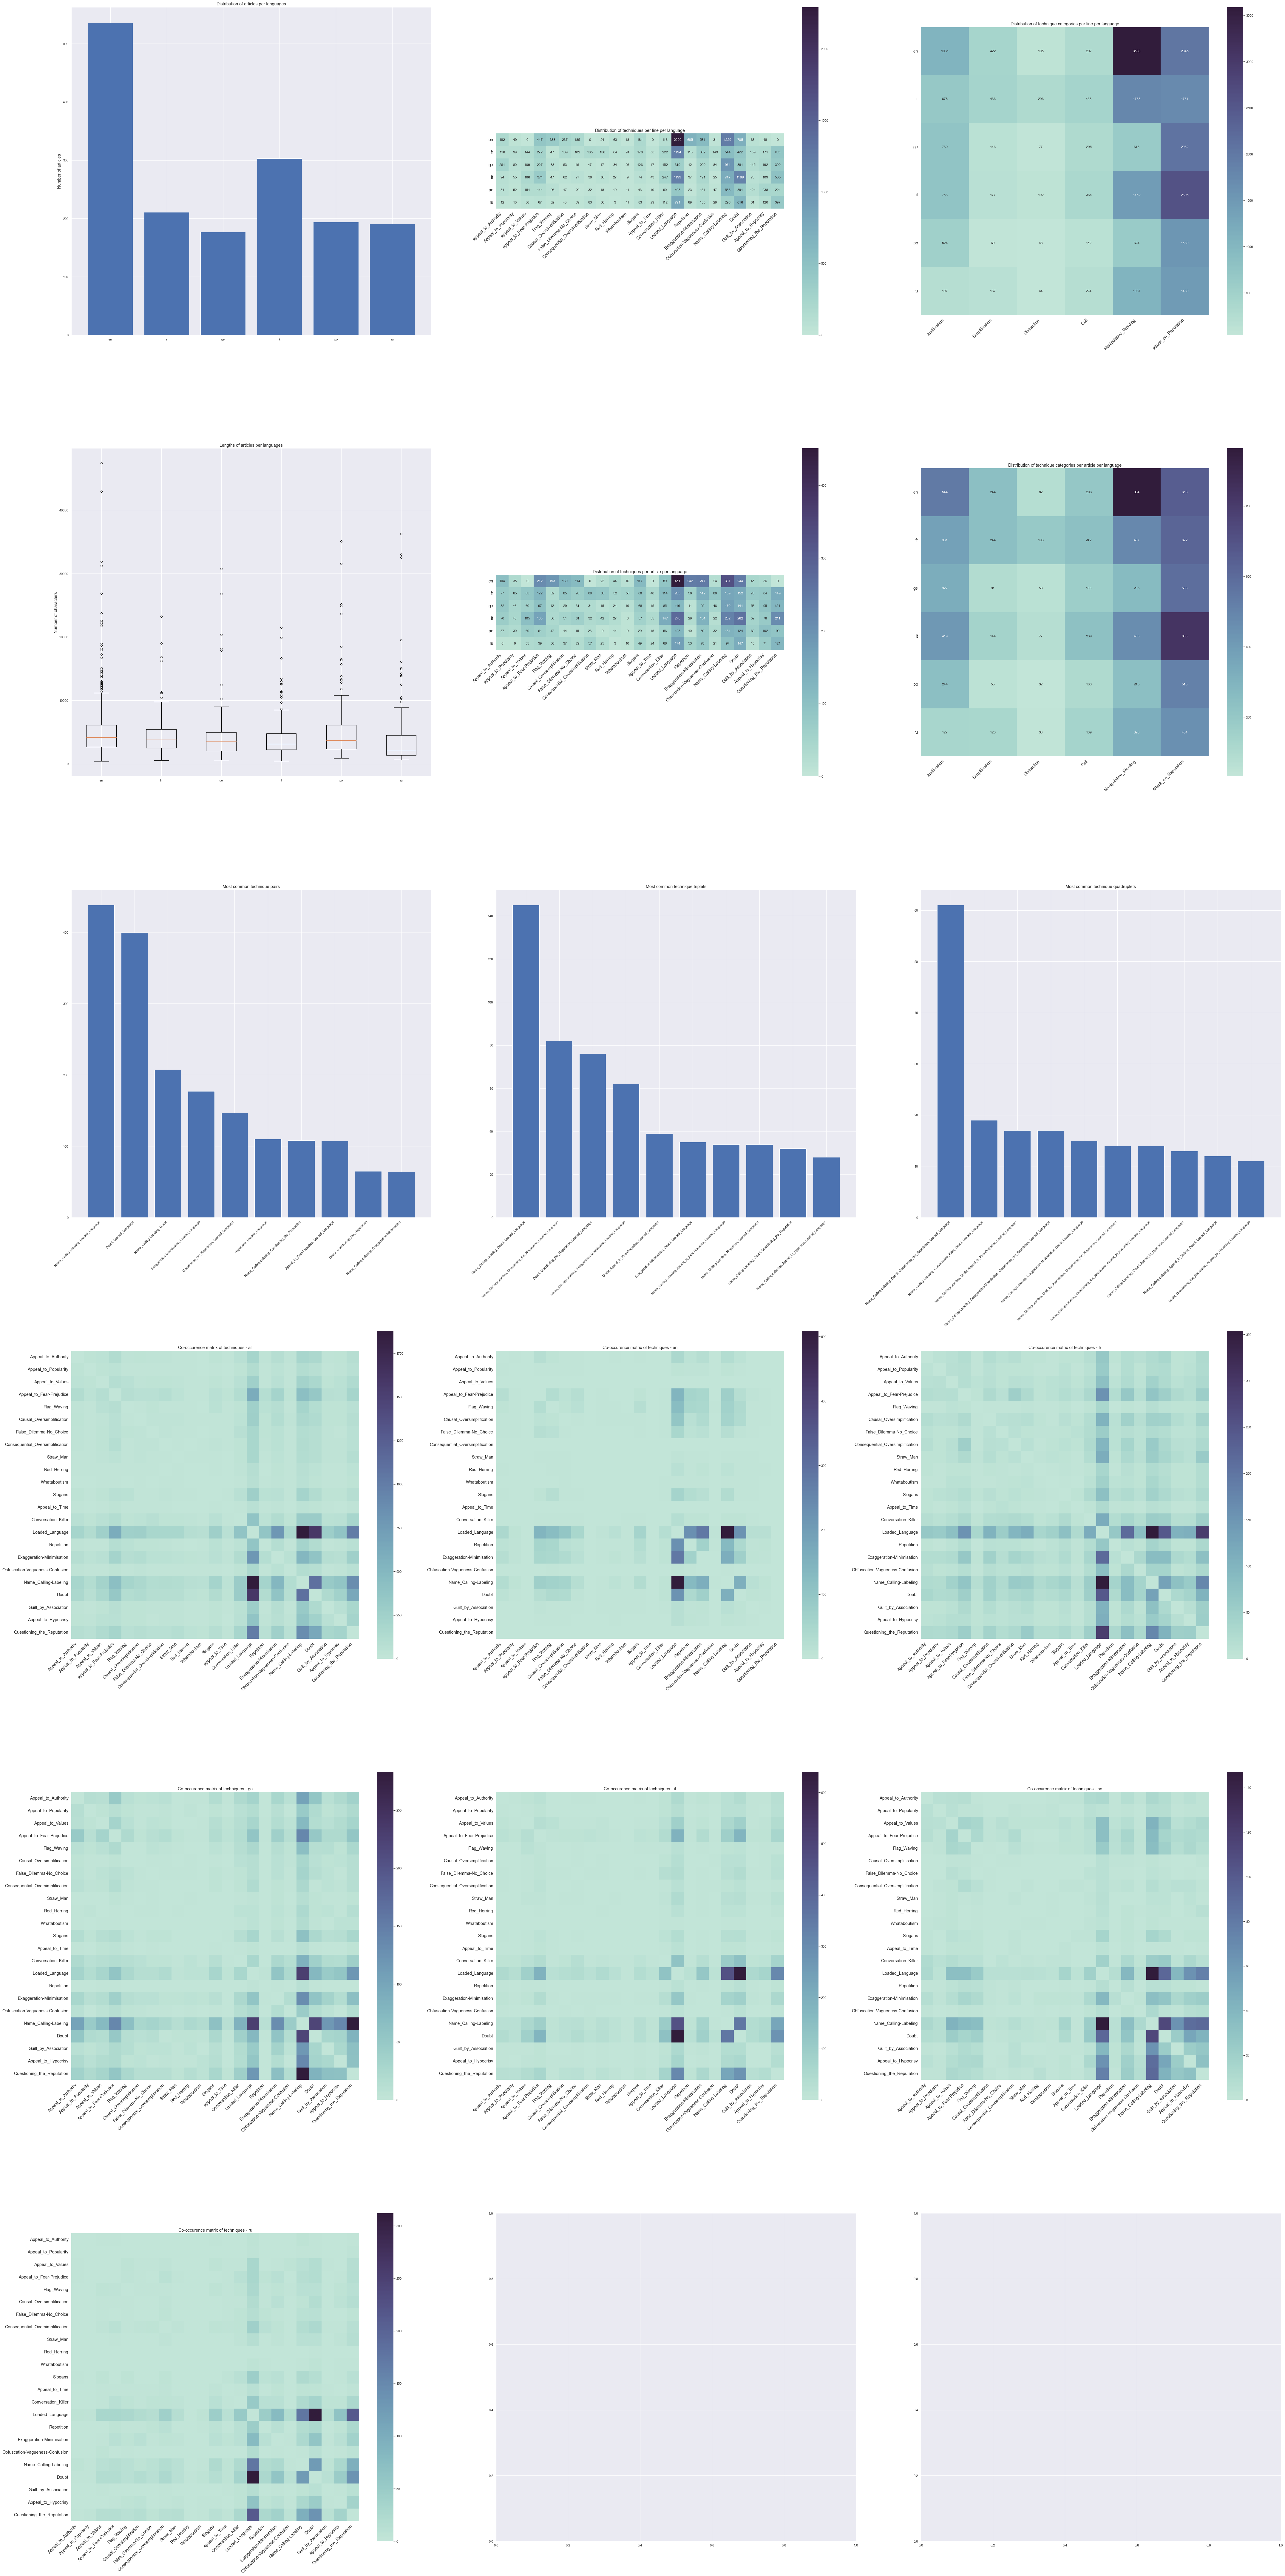

In [37]:
load_graphs(*data_results)

,Appeal_to_Authority,Appeal_to_Popularity,Appeal_to_Values,Appeal_to_Fear-Prejudice,Flag_Waving,Causal_Oversimplification,False_Dilemma-No_Choice,Consequential_Oversimplification,Straw_Man,Red_Herring,...,Conversation_Killer,Loaded_Language,Repetition,Exaggeration-Minimisation,Obfuscation-Vagueness-Confusion,Name_Calling-Labeling,Doubt,Guilt_by_Association,Appeal_to_Hypocrisy,Questioning_the_Reputation
en,182,49,0,447,383,237,185,0,24,63,...,116,2292,685,581,31,1229,705,63,48,0
fr,116,99,144,272,47,169,102,165,158,64,...,222,1194,113,332,149,544,422,159,171,435
ge,261,80,109,227,83,53,46,47,17,34,...,152,319,12,200,84,974,381,145,192,390
it,94,55,186,371,47,62,77,38,66,27,...,247,1199,37,191,25,747,1169,75,109,505
po,81,52,151,144,96,17,20,32,18,19,...,90,403,23,151,47,586,391,124,238,221
ru,12,10,56,67,52,45,39,83,30,3,...,112,791,89,158,29,296,616,31,120,397


,Appeal to Authority,Appeal to Popularity,Appeal to Values,Appeal to Fear-Prejudice,Flag Waving,Causal Oversimplification,False Dilemma-No Choice,Consequential Oversimplification,Straw Man,Red Herring,...,Conversation Killer,Loaded Language,Repetition,Exaggeration-Minimisation,Obfuscation-Vagueness-Confusion,Name Calling-Labeling,Doubt,Guilt by Association,Appeal to Hypocrisy,Questioning the Reputation
en,182,49,0,447,383,237,185,0,24,63,...,116,2292,685,581,31,1229,705,63,48,0
fr,116,99,144,272,47,169,102,165,158,64,...,222,1194,113,332,149,544,422,159,171,435
ge,261,80,109,227,83,53,46,47,17,34,...,152,319,12,200,84,974,381,145,192,390
it,94,55,186,371,47,62,77,38,66,27,...,247,1199,37,191,25,747,1169,75,109,505
po,81,52,151,144,96,17,20,32,18,19,...,90,403,23,151,47,586,391,124,238,221
ru,12,10,56,67,52,45,39,83,30,3,...,112,791,89,158,29,296,616,31,120,397


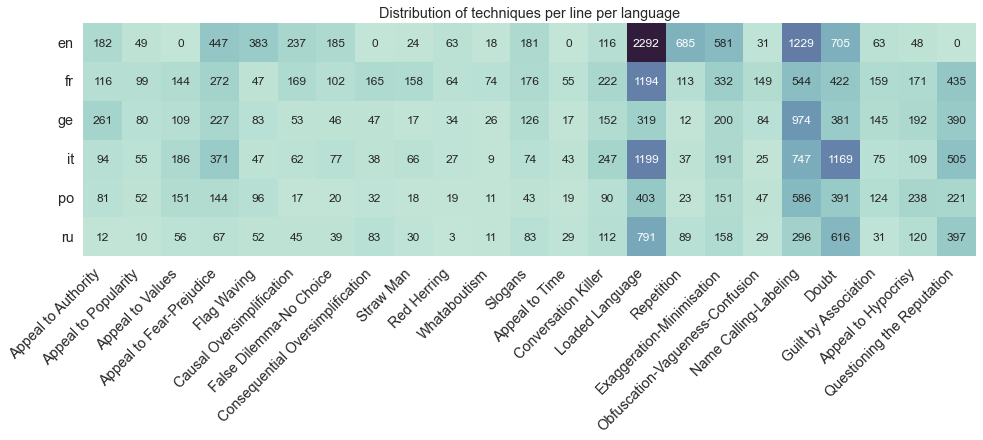

In [60]:
# Get heatmap for paper submission

fig = plt.figure(figsize=(16,12))
line_techniques_df = data_results[2].copy()
line_techniques_df.columns = line_techniques_df.columns.str.replace('_', ' ')
plot_heatmap(fig.add_subplot(1, 1, 1), line_techniques_df, "Distribution of techniques per line per language", annotate=True, cbar=False)
fig.savefig("Distribution of techniques per line per language.pdf", bbox_inches="tight", pad_inches=0.2)

In [7]:
semeval_results = pd.read_csv('semeval_results.csv')

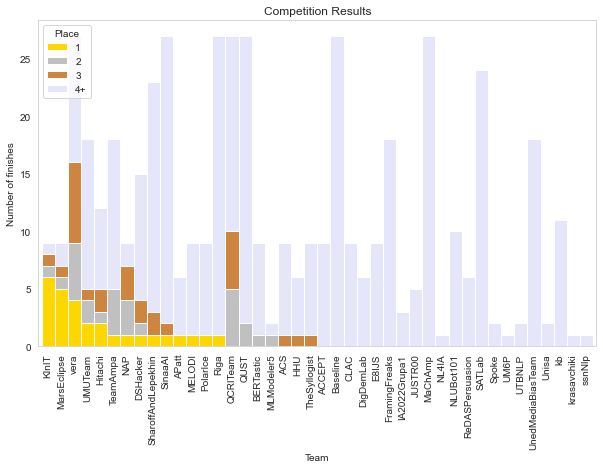

In [74]:
import matplotlib.pyplot as plt
import pandas as pd

#only_subtask3 = semeval_results[semeval_results['Subtask'] == 3]
grouped = semeval_results.groupby(['Team', 'Rank'])
counts = grouped.size().reset_index(name='Count')
df = counts.pivot(index='Team', columns='Rank', values='Count').fillna(0)
df = df.reset_index()
df = df.sort_values(by=[1, 2, 3], ascending=[False, False, False])

df = df[['Team', 1, 2, 3, *range(4, 24)]]
df['4+'] = df.iloc[:, 4:].sum(axis=1)

df = df[['Team', 1, 2, 3, '4+']]

df = df.set_index('Team')

df.plot.bar(stacked=True, color=['gold', 'silver', 'peru', 'lavender'], figsize=(10, 6), width=1)

plt.grid(False)
plt.legend(title='Place', loc='upper left')
plt.title('Competition Results')
plt.xlabel('Team')
plt.ylabel('Number of finishes')

plt.show()


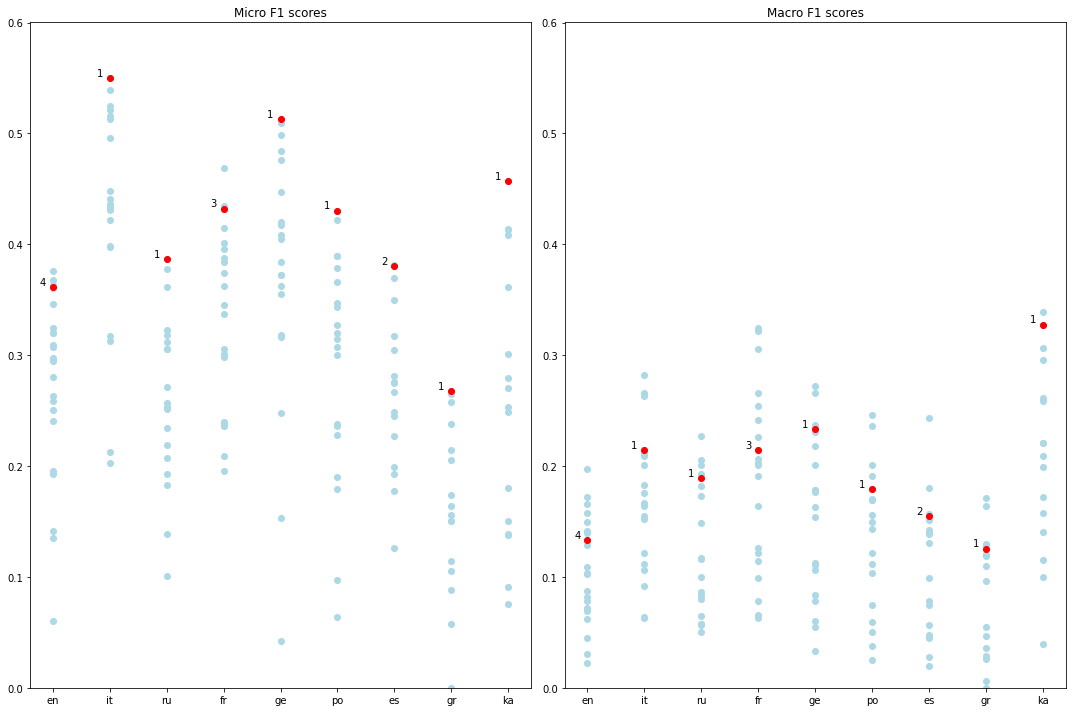

In [42]:
# Graph subtask3 scores

# Load data
df = pd.read_csv("semeval_results.csv")
df = df[df['Subtask'] == 3]
import matplotlib.pyplot as plt
import numpy as np

# plot the macro f1 scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
languages = df['Language'].unique()
for i, lang in enumerate(languages):
    lang_df = df[df['Language'] == lang]
    ax1.scatter(i * np.ones(len(lang_df)), lang_df['F1 macro'], color='lightblue')
    red_df = lang_df[lang_df['Team'] == 'KInIT']
    ax1.scatter(i * np.ones(len(red_df)), red_df['F1 macro'], color='red')
    for index, row in red_df.iterrows():
        ax1.annotate(str(row['Rank']), (i, row['F1 macro']), xytext=(-10, 10), textcoords='offset points', ha='center', va='top')
ax1.set_xticks(range(len(languages)))
ax1.set_xticklabels(languages)
ax1.set_title('Micro F1 scores')

# plot the micro f1 scores
for i, lang in enumerate(languages):
    lang_df = df[df['Language'] == lang]
    ax2.scatter(i * np.ones(len(lang_df)), lang_df['F1 micro'], color='lightblue')
    red_df = lang_df[lang_df['Team'] == 'KInIT']
    ax2.scatter(i * np.ones(len(red_df)), red_df['F1 micro'], color='red')
    for index, row in red_df.iterrows():
        ax2.annotate(str(row['Rank']), (i, row['F1 micro']), xytext=(-10, 10), textcoords='offset points', ha='center', va='top')
ax2.set_xticks(range(len(languages)))
ax2.set_xticklabels(languages)
ax2.set_title('Macro F1 scores')


ylim = [min(df['F1 macro'].min(), df['F1 micro'].min()),
        max(df['F1 macro'].max(), df['F1 micro'].max()) + 0.05]
ax1.set_ylim(ylim)
ax2.set_ylim(ylim)

fig.set_facecolor("white")
plt.tight_layout()
plt.show()


In [7]:
df.dtypes

Language     object
Subtask       int64
Rank          int64
Team         object
F1 macro    float64
F1 micro    float64
dtype: object

In [10]:
df['Team'].value_counts()

Baseline              27
SinaaAI               27
vera                  27
MaChAmp               27
QCRITeam              27
Riga                  27
QUST                  27
SATLab                24
SharoffAndLepekhin    23
UnedMediaBiasTeam     18
FramingFreaks         18
TeamAmpa              18
UMUTeam               18
DSHacker              15
Hitachi               12
kb                    11
NLUBot101             10
E8IJS                  9
ACCEPT                 9
BERTastic              9
TheSyllogist           9
MELODI                 9
ACS                    9
PolarIce               9
KInIT                  9
CLAC                   9
NAP                    9
MarsEclipse            9
APatt                  6
DigDemLab              6
ReDASPersuasion        6
HHU                    6
JUSTR00                5
IA2022Grupa1           3
Spoke                  2
MLModeler5             2
Unisa                  2
UTBNLP                 2
ssnNlp                 1
krasavchiki            1
